In [7]:
from scipy.sparse import csr_matrix, load_npz
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import random
import time
import zarr

In [14]:
def load_data():
    partition = np.load('../data/ds1_cluster_ids.npy')
    partition -= partition.min()
    graph_csr = load_npz('../data/ds1_graph.npz')
    print(graph_csr.shape)
    print(graph_csr.nnz)
    return graph_csr, partition

In [15]:
graph_csr, partition = load_data()

(7072, 7072)
77792


In [20]:
num_features = 10000
ram_size_allocated = 1*1024*1024 # (1MB)
num_rows = ram_size_allocated // (num_features*8) # 8 for int64
# feature_matrix = zarr.open('../data/ds1_features.zarr', mode='a', chunks=(num_rows, num_features), dtype='i4')
feature_matrix = zarr.open('../data/ds1_features.zarr', mode='a', chunks=(num_rows, num_features), dtype='i4')
feature_matrix.info

Type,zarr.core.Array
Data type,int64
Shape,"(7072, 10)"
Chunk shape,"(3536, 10)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,565760 (552.5K)
No. bytes stored,73249 (71.5K)
Storage ratio,7.7


In [18]:
print(f'Num of Chunks: {feature_matrix.nchunks}')
print(f'Chunk Shape: {feature_matrix.chunks}')

Num of Chunks: 2
Chunk Shape: (3536, 10)


In [19]:
for i in range(512):
    try:
        block = feature_matrix.get_block_selection(i)
        print(block.shape)
    except:
        print('error', i)
        break

(3536, 10)
(3536, 10)
error 2


In [24]:
np.random.seed(42)

In [210]:
feature_matrix = np.random.randint(0, 100, (7072, 1001))
feature_matrix = zarr.array(feature_matrix, store='../data/tmp.zarr', overwrite=True)
feature_matrix.info

Type,zarr.core.Array
Data type,int64
Shape,"(7072, 1001)"
Chunk shape,"(884, 126)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,56632576 (54.0M)
No. bytes stored,7321272 (7.0M)
Storage ratio,7.7


In [212]:
feature_matrix_pd = np.array(feature_matrix)
feature_matrix_pd

array([[ 0, 28, 68, ..., 32, 93, 72],
       [98, 39, 55, ..., 72, 93, 27],
       [34, 74,  8, ..., 86, 86, 78],
       ...,
       [80, 40, 71, ..., 38, 54, 29],
       [30, 31, 32, ..., 49, 19, 63],
       [16, 34, 54, ..., 22, 21, 36]])

In [213]:
chunk_size=1000
n, f = feature_matrix_pd.shape
total_ranks = None
num_chunks = (n + chunk_size - 1) // chunk_size
for i in range(num_chunks):
    start = i * chunk_size
    end = min(n, (i+1) * chunk_size)
    print(f'Processing chunk {i+1}/{num_chunks} with {end-start} nodes')
    chunk = feature_matrix_pd[start:end, :] # get chunk of feature matrix
    chunk_df = pd.DataFrame(chunk) # convert to pandas dataframe
    chunk_ranks = chunk_df.rank(method='dense', ascending=False) # rank the chunk -- dense ranking with descending order; rank 1 is the highest number
    group_chunk = pd.Series(partition[start:end])

    chunk_ranks_grouped = chunk_ranks.groupby(group_chunk).sum()
    # Check if chunk_ranks_grouped has all the partitions, if not add the missing ones and assign 0
    missing_partitions = set(partition) - set(chunk_ranks_grouped.index)

    if missing_partitions:
        for p in missing_partitions:
            chunk_ranks_grouped.loc[p] = 0
    if total_ranks is None:
        total_ranks = chunk_ranks_grouped
    else:
        total_ranks += chunk_ranks_grouped
        
mean_ranks = total_ranks / n
score = mean_ranks.reindex(set(partition))
score = score / score.sum() # Normalize the scores
score_pd = pd.DataFrame(score)
score_pd

Processing chunk 1/8 with 1000 nodes
Processing chunk 2/8 with 1000 nodes
Processing chunk 3/8 with 1000 nodes
Processing chunk 4/8 with 1000 nodes
Processing chunk 5/8 with 1000 nodes
Processing chunk 6/8 with 1000 nodes
Processing chunk 7/8 with 1000 nodes
Processing chunk 8/8 with 72 nodes


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.148514,0.142456,0.144287,0.147360,0.146192,0.148034,0.148262,0.144701,0.148643,0.147078,...,0.147176,0.145593,0.148151,0.147929,0.144579,0.144179,0.141873,0.143529,0.143908,0.145543
1,0.136885,0.136671,0.134136,0.137618,0.135810,0.139005,0.134056,0.133985,0.137043,0.133708,...,0.136093,0.137143,0.135741,0.136983,0.140267,0.134252,0.133417,0.133761,0.138402,0.138290
2,0.118808,0.116370,0.118345,0.119994,0.119057,0.113999,0.115564,0.119685,0.119332,0.119408,...,0.120017,0.121113,0.118964,0.116975,0.121710,0.117938,0.116017,0.115523,0.118131,0.121621
3,0.100092,0.101677,0.101660,0.098134,0.099635,0.100259,0.101183,0.099753,0.099085,0.100258,...,0.101153,0.099481,0.098780,0.101871,0.099874,0.098831,0.103386,0.103259,0.097318,0.096700
4,0.095083,0.093176,0.094288,0.095881,0.093955,0.097184,0.093070,0.100398,0.096053,0.095842,...,0.095576,0.093748,0.093865,0.093280,0.098092,0.096016,0.093778,0.094126,0.099478,0.090858
5,0.061861,0.061634,0.062417,0.060517,0.060536,0.060101,0.063119,0.059696,0.061719,0.061152,...,0.060791,0.061645,0.060792,0.064026,0.061712,0.059440,0.063872,0.062264,0.060302,0.062875
6,0.056735,0.060889,0.059441,0.058794,0.061775,0.057553,0.059771,0.059555,0.062306,0.060110,...,0.062387,0.060001,0.060292,0.057822,0.055097,0.060637,0.060243,0.062476,0.058645,0.059662
7,0.058902,0.059084,0.056682,0.059426,0.059814,0.059742,0.058070,0.057122,0.057435,0.058298,...,0.058842,0.057667,0.055057,0.059723,0.056644,0.060044,0.059862,0.056452,0.057658,0.058073
8,0.042467,0.044015,0.043881,0.043576,0.041582,0.044136,0.043192,0.043885,0.043532,0.042330,...,0.045255,0.042148,0.045898,0.042210,0.042085,0.044738,0.043457,0.046411,0.042871,0.045795
9,0.040876,0.037971,0.039814,0.039147,0.039638,0.039785,0.039736,0.041824,0.037348,0.039428,...,0.037562,0.039949,0.041326,0.038296,0.038106,0.040392,0.040209,0.040170,0.039591,0.040963


In [60]:
import sys
sys.getsizeof(feature_matrix)

48

In [263]:
feature_matrix = np.random.randint(0, 100, (7072, 1001))
feature_matrix = zarr.array(feature_matrix, store='../data/tmp.zarr', overwrite=True)
feature_matrix.info

Type,zarr.core.Array
Data type,int64
Shape,"(7072, 1001)"
Chunk shape,"(884, 126)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,56632576 (54.0M)
No. bytes stored,7321167 (7.0M)
Storage ratio,7.7


In [264]:
import math
feature_matrix.nchunks, feature_matrix.chunks
row_chunks = math.ceil(feature_matrix.shape[0] / feature_matrix.chunks[0])
col_chunks = math.ceil(feature_matrix.shape[1] / feature_matrix.chunks[1])

In [265]:
row_chunks, col_chunks, row_chunks * col_chunks

(8, 8, 64)

In [266]:
for i in range(512):
    try:
        block = feature_matrix.get_block_selection(i)
        print(block.shape)
    except:
        print('error', i)
        break

(884, 1001)
(884, 1001)
(884, 1001)
(884, 1001)
(884, 1001)
(884, 1001)
(884, 1001)
(884, 1001)
error 8


In [325]:
for i in range(row_chunks):
    for j in range(col_chunks):
        print(feature_matrix.get_block_selection((i, j)), end='\n\n')
    print('=======================\n\n')

[[ 3 97 83 ... 98 70 10]
 [54 88 69 ... 96 37 10]
 [86 85  1 ...  2 29 15]
 ...
 [ 5 12 72 ... 82 44 46]
 [11 50 66 ... 46 60 43]
 [99 11 91 ... 45 89 99]]

[[ 6 92 72 ... 50 98 92]
 [29 26 40 ... 28 54 80]
 [ 9 43  5 ... 60 31 80]
 ...
 [93 30 45 ... 86 83 46]
 [68 70 69 ... 96 32 38]
 [21 86 46 ... 64  7  5]]

[[90  8 46 ... 72 92  0]
 [ 9 78 47 ... 45 32 85]
 [18 87 71 ... 78 48 11]
 ...
 [ 6 36 46 ... 41 75 36]
 [88 22 90 ...  5 26 92]
 [22 42 39 ... 41 28 22]]

[[83 42 13 ... 64 28 70]
 [50 13 83 ... 19 67 20]
 [55 87 11 ... 47 67 62]
 ...
 [97 37 86 ... 56 16  4]
 [ 5 41 80 ...  3 74  8]
 [28 19 21 ...  2 28 96]]

[[75 71 27 ... 27  3  3]
 [94 33 84 ... 87 63 88]
 [ 2 25 78 ... 91 12  5]
 ...
 [67 64 46 ... 24 39 84]
 [62 81 44 ... 15 13 23]
 [80  3 69 ... 58 31 85]]

[[23 66  6 ... 98 25 12]
 [18 74 37 ... 81 70 48]
 [ 4 84  8 ... 75 40 82]
 ...
 [ 4 11 10 ... 31 50 99]
 [49 15 88 ...  1 80 86]
 [51 64 62 ... 71  9 35]]

[[84 17 84 ... 26 33 85]
 [23  1 59 ... 60 56 86]
 [27  0 

In [326]:
n, f = feature_matrix.shape
row_chunks = math.ceil(n / feature_matrix.chunks[0])
col_chunks = math.ceil(f / feature_matrix.chunks[1])
feature_total_ranks = {}
for col in range(col_chunks):
    feature_total_ranks[col] = None

for row in range(row_chunks):
    row_idx_start = row * feature_matrix.chunks[0]
    row_idx_end = min(n, (row+1) * feature_matrix.chunks[0])
    group_chunk = pd.Series(partition[row_idx_start:row_idx_end])
    # print(f'Processing row chunk {row+1}/{row_chunks} with {row_idx_end-row_idx_start} nodes')
    # print(f'Start: {row_idx_start}, End: {row_idx_end}')
    for col in range(col_chunks):
        # print(f'\tProcessing col chunk {col+1}/{col_chunks}')
        # print(f'\tStart: {col * feature_matrix.chunks[1]}, End: {min(f, (col+1) * feature_matrix.chunks[1])}')
        chunk = feature_matrix.get_block_selection((row, col))
        chunk_df = pd.DataFrame(chunk)
        chunk_ranks = chunk_df.rank(method='dense', ascending=False)
        chunk_ranks_grouped = chunk_ranks.groupby(group_chunk).sum()
        missing_partitions = set(partition) - set(chunk_ranks_grouped.index)
        if missing_partitions:
            for p in missing_partitions:
                chunk_ranks_grouped.loc[p] = 0
        if feature_total_ranks[col] is None:
            feature_total_ranks[col] = chunk_ranks_grouped
        else:
            feature_total_ranks[col] += chunk_ranks_grouped
concat_df = None
for key, df, in feature_total_ranks.items():
    df = df.sort_index()
    concat_df = pd.concat([concat_df, df], axis=1)

mean_ranks = concat_df / n
score = mean_ranks.reindex(set(partition))
score = score / score.sum() # Normalize the scores
score_pd = pd.DataFrame(score)

In [328]:
score_pd

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,0.148412,0.141388,0.144200,0.149821,0.149696,0.143125,0.147829,0.143772,0.145567,0.140814,...,0.148627,0.145309,0.144252,0.144595,0.145870,0.146912,0.146206,0.146389,0.143762,0.149473
1,0.135945,0.136125,0.139530,0.135798,0.138136,0.139285,0.139602,0.138587,0.137643,0.135452,...,0.137474,0.137928,0.135498,0.136240,0.137270,0.135838,0.137558,0.133728,0.135203,0.134908
2,0.116794,0.121306,0.116566,0.118831,0.114301,0.121376,0.118969,0.120230,0.118347,0.121212,...,0.117165,0.117582,0.115587,0.119926,0.118257,0.118676,0.118350,0.118483,0.118830,0.119487
3,0.100113,0.100830,0.099593,0.098814,0.100467,0.098193,0.099702,0.097163,0.097947,0.099255,...,0.098802,0.100175,0.102010,0.104339,0.099268,0.098027,0.101956,0.098356,0.100594,0.098839
4,0.094055,0.097851,0.095737,0.092979,0.095560,0.097891,0.091240,0.094503,0.094870,0.094634,...,0.096736,0.096945,0.096462,0.093203,0.095213,0.097624,0.094809,0.095819,0.094455,0.095322
5,0.061856,0.061663,0.061747,0.060973,0.058034,0.061448,0.061003,0.062820,0.061241,0.061733,...,0.060975,0.063067,0.060083,0.062907,0.062305,0.061673,0.061107,0.060822,0.060659,0.059582
6,0.062188,0.060102,0.058707,0.060222,0.059573,0.061459,0.060975,0.059767,0.059219,0.060005,...,0.061117,0.061680,0.059038,0.057033,0.059020,0.062662,0.058264,0.062016,0.059866,0.058535
7,0.058264,0.056211,0.057592,0.059309,0.059963,0.057989,0.060641,0.058040,0.057011,0.056883,...,0.056988,0.055684,0.058133,0.058763,0.056988,0.058693,0.060542,0.055240,0.056521,0.057889
8,0.044144,0.042734,0.047254,0.043065,0.042820,0.041869,0.041886,0.044570,0.045791,0.043980,...,0.044377,0.043340,0.043497,0.042061,0.043935,0.043565,0.043485,0.043692,0.043640,0.044379
9,0.038991,0.040000,0.037549,0.038166,0.039483,0.038667,0.038846,0.037786,0.038386,0.041743,...,0.039512,0.037966,0.038899,0.039660,0.039613,0.038012,0.038770,0.039615,0.040379,0.042399


<Axes: >

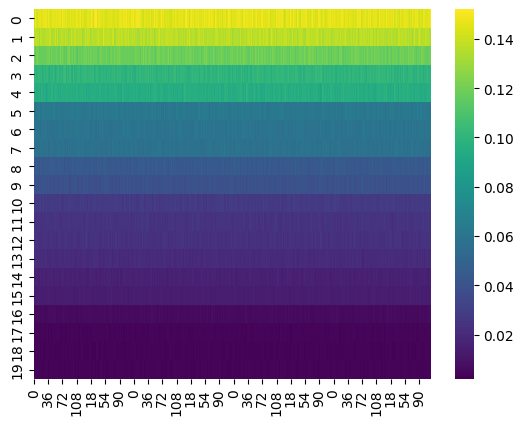

In [329]:
sns.heatmap(score_pd, cmap='viridis') # righjt now group 0 more as it has more nodes

In [330]:
feature_total_ranks.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [331]:
df0 = feature_total_ranks[0].sort_index()
df1 = feature_total_ranks[1].sort_index()
df2 = feature_total_ranks[2].sort_index()
df3 = feature_total_ranks[3].sort_index()

In [332]:
df = pd.concat([df0, df1], axis=1)
df = pd.concat([df, df2], axis=1)
df = pd.concat([df, df3], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,53140.0,50882.0,51749.0,53485.0,52925.0,50644.0,53056.0,52044.0,51896.0,50550.0,...,52547.0,52174.0,52776.0,50125.0,49919.0,53789.0,54845.0,52218.0,53044.0,52525.0
1,48676.0,48988.0,50073.0,48479.0,48838.0,49285.0,50103.0,50167.0,49071.0,48625.0,...,50612.0,47625.0,49094.0,49071.0,47749.0,49070.0,48584.0,46526.0,48446.0,48042.0
2,41819.0,43655.0,41832.0,42422.0,40411.0,42948.0,42698.0,43522.0,42192.0,43513.0,...,42059.0,41908.0,42881.0,41796.0,42191.0,41596.0,44475.0,43895.0,42863.0,42206.0
3,35846.0,36286.0,35741.0,35276.0,35520.0,34745.0,35783.0,35172.0,34919.0,35631.0,...,34076.0,35776.0,35657.0,35981.0,35734.0,36194.0,34497.0,34410.0,36738.0,36019.0
4,33677.0,35214.0,34357.0,33193.0,33785.0,34638.0,32746.0,34209.0,33822.0,33972.0,...,33910.0,35470.0,33760.0,33682.0,34163.0,34238.0,34020.0,34025.0,33542.0,33889.0
5,22148.0,22191.0,22159.0,21767.0,20518.0,21743.0,21894.0,22740.0,21833.0,22161.0,...,23020.0,22160.0,21490.0,21933.0,21823.0,22244.0,21928.0,22970.0,22265.0,22592.0
6,22267.0,21629.0,21068.0,21499.0,21062.0,21747.0,21884.0,21635.0,21112.0,21541.0,...,20918.0,21680.0,21081.0,21868.0,20518.0,20879.0,21899.0,22499.0,21454.0,21584.0
7,20862.0,20229.0,20668.0,21173.0,21200.0,20519.0,21764.0,21010.0,20325.0,20420.0,...,21991.0,20551.0,20314.0,21234.0,20656.0,20825.0,21316.0,21664.0,21152.0,19699.0
8,15806.0,15379.0,16958.0,15374.0,15139.0,14815.0,15033.0,16134.0,16325.0,15788.0,...,15188.0,15190.0,15973.0,15081.0,15903.0,15791.0,16086.0,15797.0,15637.0,16268.0
9,13961.0,14395.0,13475.0,13625.0,13959.0,13682.0,13942.0,13678.0,13685.0,14985.0,...,14000.0,15022.0,14899.0,14420.0,14536.0,14711.0,14224.0,14793.0,14374.0,14917.0


In [333]:
partition.min(), partition.max()

(0, 19)

In [334]:
groups = set(partition)
groups
sim_matrix = {g: {h: 0 for h in groups} for g in groups}
# Add self-relationships
for g in groups:
    sim_matrix[g][g] = 1  # or any other appropriate value

In [335]:
graph = nx.from_scipy_sparse_array(graph_csr)
node_group_map = dict(zip(range(len(partition)), partition))
nx.set_node_attributes(graph, node_group_map, 'group')
# Graph Data
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Density:", nx.density(graph))
print("Number of connected components:", nx.number_connected_components(graph))
print("First 10 edge weights:", list(graph.edges(data=True))[:10])

Number of nodes: 7072
Number of edges: 58327
Density: 0.0023327948391588613
Number of connected components: 1
First 10 edge weights: [(0, 18, {'weight': 0.3559792637825012}), (0, 242, {'weight': 1.0}), (0, 1431, {'weight': 0.3583466708660126}), (0, 3179, {'weight': 0.49503839015960693}), (0, 3656, {'weight': 0.46911823749542236}), (0, 4840, {'weight': 0.6180887222290039}), (0, 4848, {'weight': 0.46416306495666504}), (0, 5547, {'weight': 0.9761890172958374}), (0, 5926, {'weight': 0.4589651823043823}), (0, 6342, {'weight': 0.45704329013824463})]


In [336]:
for u, v, data in graph.edges(data=True):
    # If the edge references a node not in the partition, skip it
    if u >= len(partition) or v >= len(partition):
        print(f"Warning: Edge ({u}, {v}) references a node not in the partition.")
        continue
    # print(u, v)
    # print(partition[u], partition[v])
    # print(data)
    # print(data.get('weight', 1))
    
    # Assign the edge weight to the similarity between the groups
    g_u, g_v = partition[u], partition[v]
    sim_matrix[g_u][g_v] += data.get('weight', 0)
    sim_matrix[g_v][g_u] += data.get('weight', 0)

In [337]:
sim_matrix = pd.DataFrame(sim_matrix)
sim_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9201.695655,0.000000,211.864667,0.000000,0.000000,0.000000,0.000000,85.732684,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,17.821263,0.000000,0.000000,0.000000,0.000000
1,0.000000,8107.746451,0.000000,0.000000,504.535979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.146211,0.000000,41.558177,0.000000,0.000000,0.000000,0.000000,11.145627,0.000000
2,211.864667,0.000000,6810.130086,0.000000,0.000000,0.000000,31.204584,30.012653,238.241621,1.310231,0.952958,0.000000,3.404847,0.000000,1.765183,25.718476,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,6353.367353,0.000000,0.000000,44.932455,0.000000,0.000000,0.000000,0.000000,0.000000,56.427843,0.000000,0.000000,0.000000,1.531000,0.000000,0.000000,0.000000
4,0.000000,504.535979,0.000000,0.000000,5465.584091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.285060,0.000000,33.966675,10.540844,0.000000,0.000000,0.000000,8.091406,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,3729.320038,53.652700,0.922579,87.949750,0.000000,0.000000,0.000000,17.483568,1.205768,0.000000,15.017884,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,31.204584,44.932455,0.000000,53.652700,3376.454423,29.782123,54.851266,0.294409,0.000000,0.000000,1.994477,0.000000,0.000000,29.334843,5.303883,0.000000,0.000000,0.000000
7,85.732684,0.000000,30.012653,0.000000,0.000000,0.922579,29.782123,3530.338687,10.478794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.548589,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,238.241621,0.000000,0.000000,87.949750,54.851266,10.478794,2321.277427,0.000000,0.000000,0.000000,2.475522,1.795281,0.000000,13.300722,0.000000,0.000000,0.000000,0.000000
9,0.418267,0.000000,1.310231,0.000000,0.000000,0.000000,0.294409,0.000000,0.000000,2376.305163,37.167736,0.000000,0.000000,0.000000,0.000000,0.000000,0.848726,0.000000,0.000000,0.000000


In [338]:
sum_deg = {}
for idx, row in sim_matrix.iterrows():
    sum = 0
    for i in range(len(row)):
        if i != idx:
            sum += row[i]
    sum_deg[idx] = sum
    print(f'Row {idx} sum: {sum}')

Row 0 sum: 315.8368809968233
Row 1 sum: 562.3859926760197
Row 2 sum: 544.4752188175917
Row 3 sum: 102.8912985920906
Row 4 sum: 619.4199634343386
Row 5 sum: 176.2322504967451
Row 6 sum: 251.3507398366928
Row 7 sum: 195.47742173075676
Row 8 sum: 409.0929562598467
Row 9 sum: 40.03936901688576
Row 10 sum: 42.222135439515114
Row 11 sum: 77.3638407588005
Row 12 sum: 92.26486118137836
Row 13 sum: 81.0732403844595
Row 14 sum: 22.772831425070763
Row 15 sum: 149.90303055942059
Row 16 sum: 9.510091498494148
Row 17 sum: 0.9937985837459564
Row 18 sum: 20.571286350488663
Row 19 sum: 4.005627349019051


In [339]:
sum_deg_s = pd.Series(sum_deg)
sum_deg_s.sort_values(ascending=False)

4     619.419963
1     562.385993
2     544.475219
8     409.092956
0     315.836881
6     251.350740
7     195.477422
5     176.232250
15    149.903031
3     102.891299
12     92.264861
13     81.073240
11     77.363841
10     42.222135
9      40.039369
14     22.772831
18     20.571286
16      9.510091
19      4.005627
17      0.993799
dtype: float64

In [340]:
type(sum_deg_s)

pandas.core.series.Series

In [341]:
sim_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9201.695655,0.000000,211.864667,0.000000,0.000000,0.000000,0.000000,85.732684,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,17.821263,0.000000,0.000000,0.000000,0.000000
1,0.000000,8107.746451,0.000000,0.000000,504.535979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.146211,0.000000,41.558177,0.000000,0.000000,0.000000,0.000000,11.145627,0.000000
2,211.864667,0.000000,6810.130086,0.000000,0.000000,0.000000,31.204584,30.012653,238.241621,1.310231,0.952958,0.000000,3.404847,0.000000,1.765183,25.718476,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,6353.367353,0.000000,0.000000,44.932455,0.000000,0.000000,0.000000,0.000000,0.000000,56.427843,0.000000,0.000000,0.000000,1.531000,0.000000,0.000000,0.000000
4,0.000000,504.535979,0.000000,0.000000,5465.584091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.285060,0.000000,33.966675,10.540844,0.000000,0.000000,0.000000,8.091406,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,3729.320038,53.652700,0.922579,87.949750,0.000000,0.000000,0.000000,17.483568,1.205768,0.000000,15.017884,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,31.204584,44.932455,0.000000,53.652700,3376.454423,29.782123,54.851266,0.294409,0.000000,0.000000,1.994477,0.000000,0.000000,29.334843,5.303883,0.000000,0.000000,0.000000
7,85.732684,0.000000,30.012653,0.000000,0.000000,0.922579,29.782123,3530.338687,10.478794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.548589,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,238.241621,0.000000,0.000000,87.949750,54.851266,10.478794,2321.277427,0.000000,0.000000,0.000000,2.475522,1.795281,0.000000,13.300722,0.000000,0.000000,0.000000,0.000000
9,0.418267,0.000000,1.310231,0.000000,0.000000,0.000000,0.294409,0.000000,0.000000,2376.305163,37.167736,0.000000,0.000000,0.000000,0.000000,0.000000,0.848726,0.000000,0.000000,0.000000


In [342]:
adjusted_scores.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118],
      dtype='int64', length=1001)

In [347]:
adjusted_scores = score.copy()
for group in adjusted_scores.index:
    for other_group in adjusted_scores.index:
        if group == other_group:
            continue
        print(f'Group {group} vs Group {other_group}')
        similarity = sim_matrix.loc[group, other_group]
        adjusted_scores.loc[group] += similarity * score.loc[other_group]
adjusted_scores = adjusted_scores / adjusted_scores.sum()

Group 0 vs Group 1
Group 0 vs Group 2
Group 0 vs Group 3
Group 0 vs Group 4
Group 0 vs Group 5
Group 0 vs Group 6
Group 0 vs Group 7
Group 0 vs Group 8
Group 0 vs Group 9
Group 0 vs Group 10
Group 0 vs Group 11
Group 0 vs Group 12
Group 0 vs Group 13
Group 0 vs Group 14
Group 0 vs Group 15
Group 0 vs Group 16
Group 0 vs Group 17
Group 0 vs Group 18
Group 0 vs Group 19
Group 1 vs Group 0
Group 1 vs Group 2
Group 1 vs Group 3
Group 1 vs Group 4
Group 1 vs Group 5
Group 1 vs Group 6
Group 1 vs Group 7
Group 1 vs Group 8
Group 1 vs Group 9
Group 1 vs Group 10
Group 1 vs Group 11
Group 1 vs Group 12
Group 1 vs Group 13
Group 1 vs Group 14
Group 1 vs Group 15
Group 1 vs Group 16
Group 1 vs Group 17
Group 1 vs Group 18
Group 1 vs Group 19
Group 2 vs Group 0
Group 2 vs Group 1
Group 2 vs Group 3
Group 2 vs Group 4
Group 2 vs Group 5
Group 2 vs Group 6
Group 2 vs Group 7
Group 2 vs Group 8
Group 2 vs Group 9
Group 2 vs Group 10
Group 2 vs Group 11
Group 2 vs Group 12
Group 2 vs Group 13
Group 2

In [348]:
adjusted_scores

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,0.093323,0.095235,0.092445,0.094894,0.092088,0.095112,0.095173,0.094966,0.093665,0.095946,...,0.092535,0.092597,0.092882,0.095762,0.093729,0.093933,0.094618,0.093761,0.094526,0.094728
1,0.149903,0.155486,0.151923,0.148754,0.153001,0.154595,0.145664,0.150199,0.151281,0.151426,...,0.153447,0.154067,0.154850,0.149309,0.152017,0.154673,0.151036,0.153398,0.151581,0.151848
2,0.143326,0.136630,0.141635,0.143299,0.142995,0.136487,0.141082,0.139578,0.141773,0.138078,...,0.142359,0.139598,0.140414,0.139234,0.140749,0.140901,0.140751,0.141600,0.140056,0.143415
3,0.013025,0.012897,0.012511,0.012733,0.012522,0.012790,0.012782,0.012704,0.012556,0.012843,...,0.012903,0.013047,0.012877,0.012436,0.012380,0.012833,0.012428,0.013271,0.013138,0.012455
4,0.219375,0.219063,0.223844,0.219621,0.223613,0.222198,0.225487,0.222628,0.221780,0.219490,...,0.220732,0.221646,0.220294,0.221311,0.221933,0.217930,0.222121,0.217055,0.219631,0.217537
5,0.024704,0.023877,0.024834,0.024019,0.023803,0.023643,0.023752,0.024277,0.024525,0.024352,...,0.024352,0.024249,0.024171,0.023336,0.024000,0.024335,0.023699,0.024630,0.024395,0.024060
6,0.050149,0.049885,0.050185,0.049772,0.049097,0.049138,0.049736,0.049911,0.049782,0.050318,...,0.049226,0.049643,0.050066,0.050951,0.049921,0.049445,0.050156,0.049585,0.050164,0.049653
7,0.059510,0.057412,0.057786,0.059671,0.059141,0.057565,0.059052,0.057953,0.058333,0.057729,...,0.058828,0.058169,0.058188,0.058303,0.058476,0.058705,0.058251,0.059089,0.058441,0.059467
8,0.116357,0.118667,0.114911,0.117327,0.113087,0.118149,0.117410,0.118123,0.116442,0.119336,...,0.115392,0.116486,0.114978,0.118458,0.116753,0.116928,0.116390,0.117420,0.117543,0.116795
9,0.004033,0.003958,0.003916,0.004290,0.004040,0.004024,0.004022,0.004083,0.004245,0.004065,...,0.004027,0.003932,0.004139,0.003949,0.003903,0.004037,0.003907,0.003992,0.004075,0.004018


<Axes: >

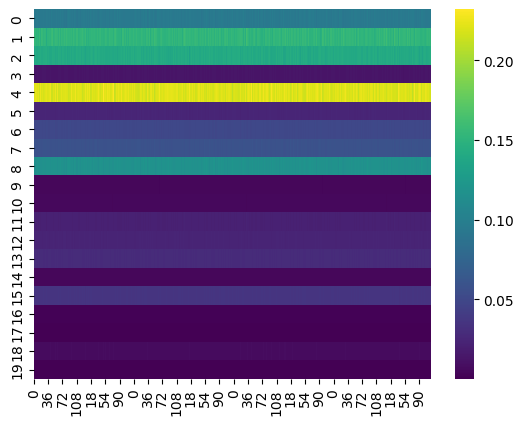

In [283]:
# cmap
sns.heatmap(adjusted_scores, cmap='viridis')

In [173]:
ranked_features = {}
for group in adjusted_scores.index:
    ranked_features[group] = adjusted_scores.loc[group].sort_values(ascending=False)

In [175]:
ranked_features.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

(array([ 10.,  46.,  75., 191., 254., 183., 161.,  59.,  17.,   5.]),
 array([0.19657921, 0.20174605, 0.20691288, 0.21207971, 0.21724655,
        0.22241338, 0.22758021, 0.23274705, 0.23791388, 0.24308072,
        0.24824755]),
 <BarContainer object of 10 artists>)

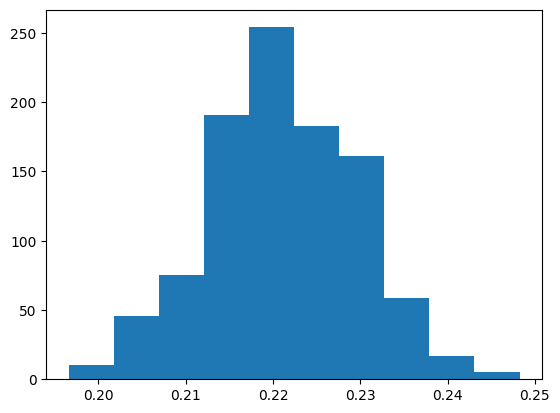

In [179]:
plt.hist(ranked_features[4])

# Functions

In [361]:
def load_data(graph_csr_path:str, partition_path:str, zarr_array_path:str) -> Tuple[csr_matrix, np.ndarray, zarr.Array]:
    """
    Load the data from the given paths.
    -------
    Args:
        - graph_csr_path: Path to the graph csr matrix
        - partition_path: Path to the partition file
        - zarr_array_path: Path to the zarr array
    Returns:
        - graph_csr: csr_matrix: The graph csr matrix
        - partition: np.ndarray: The partition array
        - feature_matrix: zarr.Array: The feature matrix
    """
    partition = np.load(partition_path)
    partition -= partition.min()
    graph_csr = load_npz(graph_csr_path)
    feature_matrix = zarr.open(zarr_array_path, mode='a')
    return graph_csr, partition, feature_matrix

In [362]:
def make_graph(graph_csr:csr_matrix, partition:np.ndarray) -> nx.Graph:
    """
    Create a graph from the csr matrix
    """
    graph = nx.from_scipy_sparse_array(graph_csr)
    node_group_map = dict(zip(range(len(partition)), partition))
    nx.set_node_attributes(graph, node_group_map, 'group')
    # Graph Data
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Density:", nx.density(graph))
    print("Number of connected components:", nx.number_connected_components(graph))
    print("First 10 edge weights:", list(graph.edges(data=True))[:10])
    return graph

In [363]:
def zarr_properties(zarr_array:zarr.Array) -> Dict[str, Any]:
    """
    Get the properties of the zarr array.
    -------
    Args:
        - zarr_array: zarr.Array: The zarr array
    Returns:
        - properties: Dict[str, Any]: The properties of the zarr array
    """
    n, f = zarr_array.shape
    chunkks = zarr_array.chunks
    row_chunks = (n // chunkks[0]) + 1
    col_chunks = (f // chunkks[1]) + 1
    properties =  {
        'n': n,
        'f': f,
        'row_chunks': row_chunks,
        'col_chunks': col_chunks,
        'chunks': chunkks,
        'nchunks': zarr_array.nchunks,
        'dtype': zarr_array.dtype
    }
    return properties

In [364]:
def calculate_scores(feature_matrix:zarr.Array, partition:np.ndarray) -> pd.DataFrame:
    """
    Calculate the scores for the given feature matrix, partition and graph csr matrix.
    -------
    Args:
        - feature_matrix: zarr.Array: The feature matrix
        - partition: np.ndarray: The partition array
        - graph_csr: csr_matrix: The graph csr matrix
    Returns:
        - scores: pd.DataFrame: The scores dataframe
    -------
    - Iterate over the chunks (in a block-wise manner) of the feature matrix and calculate the scores.
    - For each row chunk, iterate over the column chunks and calculate the ranks.
    - For each column chunk, calculate the ranks and group them by the partition.
    """
    n, f = feature_matrix.shape
    row_chunks = math.ceil(n / feature_matrix.chunks[0])
    col_chunks = math.ceil(f / feature_matrix.chunks[1])
    # Initialize the total ranks as a dictionary. Each key is a column chunk and the value is None.
    # Each row chunk has a total rank for all its column chunks.
    total_ranks = {}
    for col in range(col_chunks):
        total_ranks[col] = None
    # Iterate over the row chunks
    for row in range(row_chunks):
        # Iterate over the column chunks for each row chunk
        row_idx_start = row * feature_matrix.chunks[0]
        row_idx_end = min(n, (row+1) * feature_matrix.chunks[0])
        group_chunk = pd.Series(partition[row_idx_start:row_idx_end]) # Get the partition for the row chunk
        for col in range(col_chunks):
            chunk = feature_matrix.get_block_selection((row, col))  # Get the chunk - block-wise to ensure memory efficiency
            chunk_df = pd.DataFrame(chunk) 
            chunk_ranks = chunk_df.rank(method='dense', ascending=False) # Rank the chunk using dense ranking. Equal values are assigned the same rank.
            chunk_ranks_grouped = chunk_ranks.groupby(group_chunk).sum() # Group the ranks by the partition
            missing_partitions = set(partition) - set(chunk_ranks_grouped.index) # Check if all the partitions are present in the grouped ranks
            if missing_partitions: # If not, add the missing partitions and assign 0
                for p in missing_partitions:
                    chunk_ranks_grouped.loc[p] = 0
            
            if total_ranks[col] is None: 
                total_ranks[col] = chunk_ranks_grouped
            else:
                total_ranks[col] += chunk_ranks_grouped
    
    # Concatenate the total ranks for each column chunk into a single dataframe and calculate the mean ranks
    concat_df = None
    for key, df, in total_ranks.items():
        df = df.sort_index()
        concat_df = pd.concat([concat_df, df], axis=1)
    
    mean_ranks = concat_df / n
    score = mean_ranks.reindex(set(partition))
    score = score / score.sum() # Normalize the scores
    score_pd = pd.DataFrame(score)
    score_pd.columns = [f'{i}' for i in range(len(score_pd.columns))]
    # For a score_pd with 1000 groups and 1000 features, the memory usage is around 7.63 MB (7812.5 KB)
    return score_pd

In [365]:
def build_graph_relationship(graph:nx.Graph, partition:np.ndarray) -> pd.DataFrame:
    """
    Analyze the relationships between the groups in the graph.
    -------
    Args:
        - graph: nx.Graph: The graph
        - partition: np.ndarray: The partition array
    Returns:
        - sim_matrix: pd.DataFrame: The similarity matrix between the groups
    -------
    - Create a similarity matrix between the groups based on the edge weights in the graph.
    - The similarity between two groups is the sum of the edge weights between the nodes in the two groups.
    """
    groups = set(partition) # Get the unique groups
    # Initialize the similarity matrix between the groups - a dictionary of dictionaries
    sim_matrix = {g: {h: 0 for h in groups} for g in groups}
    # Add self-relationships
    for g in groups:
        sim_matrix[g][g] = 1
    # Add the edge weights to the similarity matrix
    for u, v, data in graph.edges(data=True):
        # If the edge references a node not in the partition, skip it
        if u >= len(partition) or v >= len(partition):
            print(f"Warning: Edge ({u}, {v}) references a node not in the partition.")
            continue

        # Assign the edge weight to the similarity between the groups
        g_u, g_v = partition[u], partition[v]
        sim_matrix[g_u][g_v] += data.get('weight', 0) # Use the get method to get the weight. If not present, assign 0
        sim_matrix[g_v][g_u] += data.get('weight', 0)
    
    sim_matrix = pd.DataFrame(sim_matrix)
    return sim_matrix

In [368]:
def graph_relationship_analysis(sim_matrix:pd.DataFrame, score:pd.DataFrame) -> pd.Series:
    """
    Analyze the relationships between the groups in the graph.
    -------
    Args:
        - sim_matrix: pd.DataFrame: The similarity matrix between the groups
        - score: pd.DataFrame: The scores dataframe
    Returns:
        - adjusted_scores: pd.DataFrame: The adjusted scores dataframe
    """
    print(f'Similarity Matrix Shape: {sim_matrix.shape}')
    print(f'\nPrtinting Row Wise Sum of Similarity Matrix')
    sum_deg = {}
    for idx, row in sim_matrix.iterrows():
        sum = 0
        for i in range(len(row)):
            if i != idx:
                sum += row[i]
        sum_deg[idx] = sum
        print(f'\tRow {idx} sum: {sum}')
    sum_deg_s = pd.Series(sum_deg)
    sum_deg_s.sort_values(ascending=False, inplace=True)
    print(f'\nTop 5 Groups with Highest Sum of Similarity')
    print(sum_deg_s.head())
    return sum_deg_s

In [381]:
def adjusted_scoring(scores:pd.DataFrame, sim_matrix:pd.DataFrame) -> pd.DataFrame:
    """
    Adjust the scores based on the relationships between the groups.
    -------
    Args:
        - scores: pd.DataFrame: The scores dataframe
        - sim_matrix: pd.DataFrame: The similarity matrix between the groups
        - partition: np.ndarray: The partition array
    Returns:
        - adjusted_scores: pd.DataFrame: The adjusted scores dataframe
    """
    adjusted_scores = scores.copy()
    for group in adjusted_scores.index:
        for other_group in adjusted_scores.index:
            if group == other_group: # Skip the same group
                continue
            # print(f'Group {group} vs Group {other_group}')
            # Similarity between the groups
            similarity = sim_matrix.loc[group, other_group]
            # Adjust the scores based on the similarity and the scores of the other group
            adjusted_scores.loc[group] += similarity * scores.loc[other_group]
    # Normalize the scores
    adjusted_scores = adjusted_scores / adjusted_scores.sum()
    return adjusted_scores

In [412]:
def visualize_change(scores:pd.DataFrame, adjusted_scores:pd.DataFrame) -> None:
    """
    Visualize the change in the scores after adjustment.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(scores, cmap='viridis', ax=ax[0])
    ax[0].set_title('Original Scores', fontsize=14)
    sns.heatmap(adjusted_scores, cmap='viridis', ax=ax[1])
    ax[1].set_title('Adjusted Scores', fontsize=14)
    plt.suptitle('Change in Scores After Adjustment', fontsize=16)
    plt.tight_layout()
    plt.show()

In [416]:
def rank_features(adjusted_scores:pd.DataFrame, feature_matrix:zarr.Array) -> Dict[int, pd.Series]:
    """
    Rank the features based on the adjusted scores of the groups.
    """
    ranked_features = {}
    for group in adjusted_scores.index:
        ranked_features[group] = adjusted_scores.loc[group].sort_values(ascending=False)
    return ranked_features

In [424]:
def group_explanation(sum_deg_s:pd.Series, ranked_features:Dict[int, pd.Series]) -> None:
    """
    Provide an explanation of the groups based on the relationships and the ranked features.
    """
    print(f'\nTop 5 Groups with Highest Sum of Similarity')
    print(sum_deg_s.head())
    print(f'\nTop 5 Features for Each Group')
    for group, features in ranked_features.items():
        print(f'\nGroup {group}')
        print(features.head())

In [374]:
graph_csr, partition, feature_matrix = load_data('../data/ds1_graph.npz', '../data/ds1_cluster_ids.npy', '../data/ds1_features.zarr')
graph = make_graph(graph_csr, partition)
feature_matrix_properties = zarr_properties(feature_matrix)

Number of nodes: 7072
Number of edges: 58327
Density: 0.0023327948391588613
Number of connected components: 1
First 10 edge weights: [(0, 18, {'weight': 0.3559792637825012}), (0, 242, {'weight': 1.0}), (0, 1431, {'weight': 0.3583466708660126}), (0, 3179, {'weight': 0.49503839015960693}), (0, 3656, {'weight': 0.46911823749542236}), (0, 4840, {'weight': 0.6180887222290039}), (0, 4848, {'weight': 0.46416306495666504}), (0, 5547, {'weight': 0.9761890172958374}), (0, 5926, {'weight': 0.4589651823043823}), (0, 6342, {'weight': 0.45704329013824463})]


In [375]:
score_pd = calculate_scores(feature_matrix, partition)

In [417]:
sim_matrix = build_graph_relationship(graph, partition)

In [418]:
sum_deg_s = graph_relationship_analysis(sim_matrix, score_pd)

Similarity Matrix Shape: (20, 20)

Prtinting Row Wise Sum of Similarity Matrix
	Row 0 sum: 315.8368809968233
	Row 1 sum: 562.3859926760197
	Row 2 sum: 544.4752188175917
	Row 3 sum: 102.8912985920906
	Row 4 sum: 619.4199634343386
	Row 5 sum: 176.2322504967451
	Row 6 sum: 251.3507398366928
	Row 7 sum: 195.47742173075676
	Row 8 sum: 409.0929562598467
	Row 9 sum: 40.03936901688576
	Row 10 sum: 42.222135439515114
	Row 11 sum: 77.3638407588005
	Row 12 sum: 92.26486118137836
	Row 13 sum: 81.0732403844595
	Row 14 sum: 22.772831425070763
	Row 15 sum: 149.90303055942059
	Row 16 sum: 9.510091498494148
	Row 17 sum: 0.9937985837459564
	Row 18 sum: 20.571286350488663
	Row 19 sum: 4.005627349019051

Top 5 Groups with Highest Sum of Similarity
4    619.419963
1    562.385993
2    544.475219
8    409.092956
0    315.836881
dtype: float64


In [426]:
sum_deg_s

4     619.419963
1     562.385993
2     544.475219
8     409.092956
0     315.836881
6     251.350740
7     195.477422
5     176.232250
15    149.903031
3     102.891299
12     92.264861
13     81.073240
11     77.363841
10     42.222135
9      40.039369
14     22.772831
18     20.571286
16      9.510091
19      4.005627
17      0.993799
dtype: float64

In [419]:
adjusted_scores = adjusted_scoring(score_pd, sim_matrix)

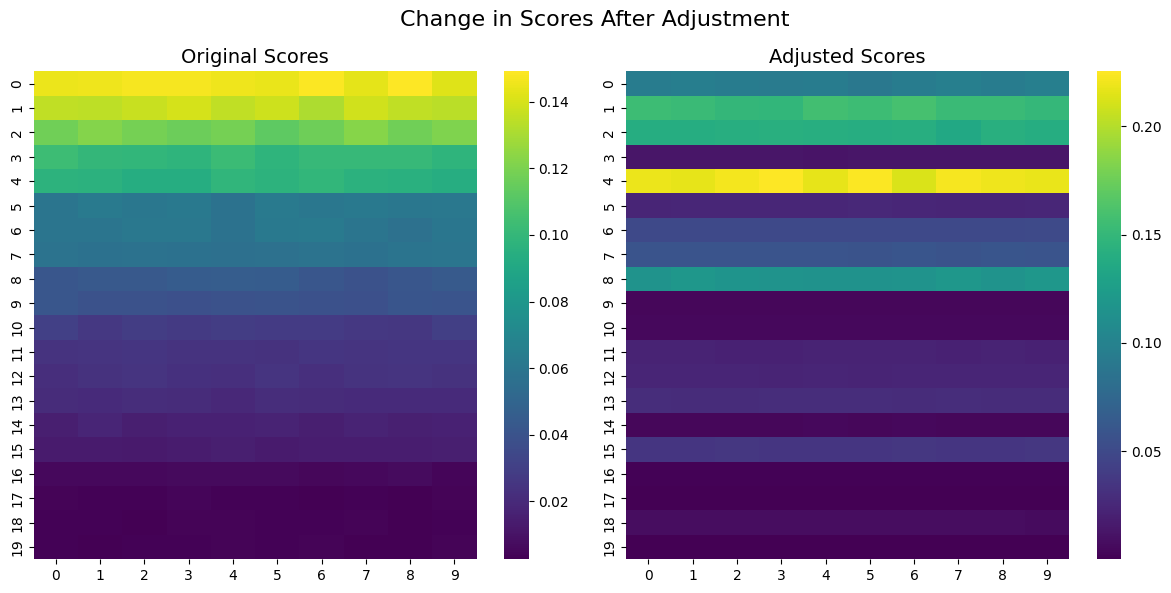

In [420]:
visualize_change(score_pd, adjusted_scores)

In [423]:
ranked_features = rank_features(adjusted_scores, feature_matrix)
ranked_features[0]

9    0.096705
7    0.096237
1    0.095880
2    0.094242
0    0.093975
8    0.093880
4    0.093599
6    0.093474
3    0.092566
5    0.090432
Name: 0, dtype: float64

In [425]:
group_explanation(sum_deg_s, ranked_features)


Top 5 Groups with Highest Sum of Similarity
4    619.419963
1    562.385993
2    544.475219
8    409.092956
0    315.836881
dtype: float64

Top 5 Features for Each Group

Group 0
9    0.096705
7    0.096237
1    0.095880
2    0.094242
0    0.093975
Name: 0, dtype: float64

Group 1
6    0.158589
4    0.156876
5    0.154980
0    0.154937
8    0.153192
Name: 1, dtype: float64

Group 2
3    0.142121
8    0.141988
6    0.141665
2    0.141392
4    0.141233
Name: 2, dtype: float64

Group 3
5    0.013202
2    0.013146
6    0.012866
9    0.012853
3    0.012825
Name: 3, dtype: float64

Group 4
3    0.225441
5    0.223728
7    0.222729
2    0.221542
8    0.219619
Name: 4, dtype: float64

Group 5
5    0.024795
3    0.024583
9    0.024403
2    0.024241
4    0.024205
Name: 5, dtype: float64

Group 6
9    0.050353
1    0.050068
0    0.049861
8    0.049830
4    0.049781
Name: 6, dtype: float64

Group 7
6    0.059414
8    0.059204
2    0.058875
3    0.058781
1    0.058392
Name: 7, dtype: float64

Grou